# Spark Collaborative-filtering Deep Dive

Spark MLlib provides collaborative filtering algorithm that can be used for training a matrix factorization model, which predicts explicit or implicit ratings of users on items, for recommendations.

This notebook presents a deep dive into Spark collaborative filtering algorithm.

## 0 Global settings


In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import product

from utilities.common.spark_utils import start_or_get_spark
from utilities.evaluation.spark_evaluation import SparkRankingEvaluation, SparkRatingEvaluation
from utilities.dataset.url_utils import maybe_download
from utilities.dataset.spark_splitters import spark_random_split

from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [6]:
DATA_URL = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
DATA_PATH = "ml-100k.data"

COL_USER = "userID"
COL_ITEM = "itemID"
COL_RATING = "rating"
COL_PREDICTION = "prediction"
COL_TIMESTAMP = "timestamp"

HEADER = {
    "col_user": COL_USER,
    "col_item": COL_ITEM,
    "col_rating": COL_RATING,
    "col_prediction": COL_PREDICTION,
}

## 1 Matrix factorization algorithm

Matrix factorization is a common technique used in recommendation tasks. Basically, a matrix factorization algorithm tries to find latent factors that represent intrinsic user and item attributes in a lower dimension. That is,

$$\hat r_{u,i} = q_{i}^{T}p_{u}$$

where $\hat r_{u,i}$ is the predicted ratings for user $u$ and item $i$, and $q_{i}^{T}$ and $p_{u}$ are latent factors for item and user, respectively. The challenge to the matrix factorization problem is to find $q_{i}^{T}$ and $p_{u}$. This is achieved by methods such as matrix decomposition. A learning approach is therefore developed to converge the decomposition results close to the observed ratings as much as possible. Furthermore, to avoid overfitting issue, the learning process is regularized. For example, a basic form of such matrix factorization algorithm is represented as below.

$$\min\sum(\hat r_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $\lambda$ is a the regularization parameter. 

In case explict ratings are not available, implicit ratings which are usually derived from users' historical interactions with the items (e.g., clicks, views, purchases, etc.). To account for such implicity ratings, the original matrix factorization algorithm can be formulated as 

$$\min\sum c_{u,i}(p_{u,i} - q_{i}^{T}p_{u})^2 + \lambda(||q_{i}||^2 + ||p_{u}||^2)$$

where $c_{u,i}=1+\alpha r_{u,i}$ and $p_{u,i}=1$ if $r_{u,i}>0$ and $p_{u,i}=0$ if $r_{u,i}=0$. $r_{u,i}$ is a numerical representation of users' preferences (e.g., number of cliks, etc.). 

## 1.1 Spark Mllib implementation

The matrix factorization algorithm is available in Spark mllib as `ALS` module. 

* The uniqueness of ALS implementation is that it distributes and parallelizes the matrix factorization model training by using "Alternating Least Square" method. 
* In the training method, there are parameters that can be selected to control the model performance.
* Both explicit and implicit ratings are supported by Spark ALS model.

## 1.2 Movielens recommender

In the following codes, Movielens-100K dataset is used to illustrate the ALS algorithm in Spark.

First, a Spark session is initialized.

In [ ]:
spark = start_or_get_spark("Spark ALS", "local")

### 1.2.1 Load and prepare data

Data is read from csv into a Spark DataFrame.

In [8]:
filepath = maybe_download(DATA_URL, DATA_PATH)

dfs = spark.read.csv(
    filepath, 
    inferSchema=True, 
    sep="\t", 
) \
.withColumnRenamed("_c0", COL_USER).withColumnRenamed("_c1", COL_ITEM) \
.withColumnRenamed("_c2", COL_RATING) \
.withColumnRenamed("_c3", COL_TIMESTAMP)

In [43]:
dfs.show(5)

+------+------+------+---------+
|userID|itemID|rating|timestamp|
+------+------+------+---------+
|   196|   242|     3|881250949|
|   186|   302|     3|891717742|
|    22|   377|     1|878887116|
|   244|    51|     2|880606923|
|   166|   346|     1|886397596|
+------+------+------+---------+
only showing top 5 rows



Data is then randomly split to 80-20 halfs for training and testing.

In [9]:
dfs_train, dfs_test = spark_random_split(dfs, ratio=0.8)

In [10]:
dfs_train = dfs_train.select(COL_USER, COL_ITEM, COL_RATING)
dfs_test = dfs_test.select(COL_USER, COL_ITEM, COL_RATING).withColumn(COL_RATING, col(COL_RATING).cast("float"))

### 1.2.2 Train a movielens model 

It is worth noting that Spark ALS model allows dropping cold users to favor a robust evaluation with the testing data. In case there are cold users, Spark ALS implementation allows users to drop cold users in order to make sure evaluations on the prediction results are sound.

In [73]:
als = ALS(
    maxIter=5, 
    rank=10,
    regParam=0.01, 
    userCol=COL_USER, 
    itemCol=COL_ITEM, 
    ratingCol=COL_RATING, 
    coldStartStrategy="drop"
)

model = als.fit(dfs_train)

### 1.2.3 Prediction with the model

The trained model can be used to predict ratings with a given test data.

In [74]:
dfs_pred = model.transform(dfs_test).drop(COL_RATING)

With the prediction results, the model performance can be evaluated.

In [60]:
evaluations = SparkRatingEvaluation(
    dfs_test, 
    dfs_pred,
    col_user=COL_USER,
    col_item=COL_ITEM,
    col_rating=COL_RATING,
    col_prediction=COL_PREDICTION
)

In [75]:
print("RMSE score is {}".format(evaluations.rmse()))

RMSE score is 1.1491326857049817


### 1.2.4 Fine tune the model

Prediction performance of a Spark ALS model is often affected by the parameters of 

|Parameter|Description|Default value|Notes|
|-------------|-----------------|------------------|-----------------|
|`rank`|Number of latent factors|10|The larger the more intrinsic factors considered in the factorization modeling.|
|`regParam`|Regularization parameter|1.0|The value needs to be selected empirically to avoid overfitting.|
|`maxIters`|Maximum number of iterations|10|The more iterations the better the model converges to the optimal point.|

It is always a good practice to start model building with default parameter values and then sweep the parameter in a range to find optimal set of parameter combination. For illustration purpose, the following parameter set is used for training ALS models for comparison study purpose.

In [37]:
param_dict = {
    "rank": [10, 15, 20],
    "regParam": [0.001, 0.1, 1.0]
}

To generate dictionary for each parameter combination which can then be fed into model training.

In [38]:
def get_grid_search(params):
    '''
    Grid search of parameters, i.e., all possible permutations.
    '''
    param_new = {}
    param_fixed = {}
    for key, value in params.items():
        if isinstance(value, list):
            param_new[key] = value
        else:
            param_fixed[key] = value

    items = sorted(param_new.items())
    keys, values = zip(*items)

    params_exp = []
    for v in product(*values):
        param_exp = dict(zip(keys, v))
        param_exp.update(param_fixed)
        params_exp.append(param_exp)

    return params_exp

param_grid = get_grid_search(param_dict)

Train models with parameters specified in the parameter grid. Evaluate the model with RMSE metric and then record the metrics for visualization.

In [67]:
rmse_score = []

for g in param_grid:
    als = ALS(
        **g,
        userCol=COL_USER, 
        itemCol=COL_ITEM, 
        ratingCol=COL_RATING, 
        coldStartStrategy="drop"
    )
    
    model = als.fit(dfs_train)
    
    dfs_pred = model.transform(dfs_test).drop(COL_RATING)
    
    evaluations = SparkRatingEvaluation(
        dfs_test, 
        dfs_pred,
        col_user=COL_USER,
        col_item=COL_ITEM,
        col_rating=COL_RATING,
        col_prediction=COL_PREDICTION
    )

    rmse_score.append(evaluations.rmse())

rmse_score = [float('%.4f' % x) for x in rmse_score]
rmse_score_array = np.reshape(rmse_score, (-1, 3))

The calculated RMSE scores can be visualized to comparatively study how model performance is affected by different parameters.

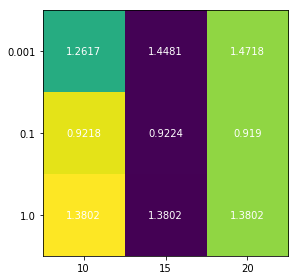

In [68]:
fig, ax = plt.subplots()
im = ax.imshow(rmse_score_array)

ax.set_xticks(np.arange(len(param_dict["rank"])))
ax.set_yticks(np.arange(len(param_dict["regParam"])))

ax.set_xticklabels(param_dict["rank"])
ax.set_yticklabels(param_dict["regParam"])

for i in range(len(param_dict["rank"])):
    for j in range(len(param_dict["regParam"])):
        text = ax.text(i, j, rmse_score_array[i, j],
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.show()

It is noted from the visualization that the RMSE does not decrease together with increase of `rank`, which may be owing to the reason of overfitting. When `rank` is 15 and `regParam` is 0.1, the lowest RMSE score is achieved, which indicates that the model is optimal.

## 2 Top K recommendation

### 2.1 Top k for all users (items)

In [69]:
dfs_rec = model.recommendForAllUsers(10)

In [70]:
dfs_rec.show(10)

+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|   471|[[814, 3.379608],...|
|   463|[[814, 3.1276853]...|
|   833|[[814, 3.2469037]...|
|   496|[[814, 3.1318862]...|
|   148|[[814, 4.046012],...|
|   540|[[814, 3.9868734]...|
|   392|[[814, 4.17356], ...|
|   243|[[814, 3.7596216]...|
|   623|[[814, 3.8591926]...|
|   737|[[814, 3.9317894]...|
+------+--------------------+
only showing top 10 rows



### 2.2 Top k for a selected set of users (items)

In [72]:
users = dfs_train.select(als.getUserCol()).distinct().limit(3)

dfs_rec_subset = model.recommendForUserSubset(users, 10)

In [73]:
dfs_rec.show(10)

+------+--------------------+
|userID|     recommendations|
+------+--------------------+
|   471|[[814, 3.379608],...|
|   463|[[814, 3.1276853]...|
|   833|[[814, 3.2469037]...|
|   496|[[814, 3.1318862]...|
|   148|[[814, 4.046012],...|
|   540|[[814, 3.9868734]...|
|   392|[[814, 4.17356], ...|
|   243|[[814, 3.7596216]...|
|   623|[[814, 3.8591926]...|
|   737|[[814, 3.9317894]...|
+------+--------------------+
only showing top 10 rows



### 2.3 Run-time consideration for top-k recommendation

It is worth noting that usually computing the top-k recommendations for all users is the bottleneck of the whole pipeline (model training and scoring) of an ALS based recommendation system. This is because
* Getting top k from all user-item pairs requires a cross join which is usually very computationally expensive. 
* Inner-product of user-item pairs are calculated individually instead of leveraging matrix block multiplication features which are available in certain contemporary computing acceleration libraries (e.g., BLAS).

More details about the deficiencies of the native implementations of the top k recommendations in Spark can be found [here](https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html).

## References

1. Yehuda Koren, Robert Bell, and Chris Volinsky, "Matrix Factorization Techniques for Recommender Systems
", ACM Computer, Vol. 42, Issue 8, pp 30-37, Aug., 2009.
2. Yifan Hu, Yehuda Koren, and Chris Volinsky, "Collaborative Filtering for Implicit Feedback Datasets
", Proc. IEEE ICDM, 2008, Dec, Pisa, Italy.
3. Apache Spark. url: https://spark.apache.org/docs/latest/ml-collaborative-filtering.html
4. matplotlib. url: https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html
5. Scaling collaborative filtering with PySpark. url: https://engineeringblog.yelp.com/2018/05/scaling-collaborative-filtering-with-pyspark.html